# CZ4041 Machine Learning Project
## Kaggle Competition: New York City Taxi Trip Duration Prediction

## Main Source Code by Group 21


---

This file (EDA_FeatureEngineering_XGBoost.ipynb) contains the source code for the following parts of our project: 
- Exploratory Data Analysis (EDA)
- Feature Engineering and Selection
- Training the XGBoost model
- Producing a prediction CSV using the test set for submission to Kaggle

Note: This notebook does not contain the Neural Networks code as it is provided in the auxilliary file named "NeuralNetworks_Auxiliary_Code.ipynb".

In this notebook, we have used two datasets from Kaggle, the links for which are shown below:

> 1. New York City Taxi Trip Duration (https://www.kaggle.com/c/nyc-taxi-trip-duration)
> 2. New York City Taxi with OSRM (https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm)

We are trying to build a model that predicts the total ride duration of taxi trips in New York City, and visualize the data. The primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

### New York City Taxi Trip Duration Dataset

* id : a unique identifier for each trip

* vendor_id : a code indicating the provider associated with the trip record

* pickup_datetime : date and time when the meter was engaged

* dropoff_datetime : date and time when the meter was disengaged

* passenger_count : the number of passengers in the vehicle (driver entered value)

* pickup_longitude : the longitude where the meter was engaged

* pickup_latitude : the latitude where the meter was engaged

* dropoff_longitude : the longitude where the meter was disengaged

* dropoff_latitude : the latitude where the meter was disengaged

* store_and_fwd_flag : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

* trip_duration : duration of the trip in seconds

### New York City Taxi with OSRM Dataset

* starting_street : The street where the taxi-trip starts. 
* end_street :The street where the taxi-trip ends. 
* total_distance :The total distance is measured between the pickup coordinates and the drop-off coordinates in train.csv and test.csv. The unit is meters.
* total_travel_time :The total travel time for that data point in seconds
* number_of_steps : The number of steps on that trip. One step consists of some driving and an action the taxi needs to perform. It can be something like a turn or going on to a highway. 
* street_for_each_step : A list of streets where each step occurs. Multiple steps can be performed on the same street. Therefore there might the same street might occur multiple times.

* distance_per_step : The distance for each step.

* travel_time_per_step : The travel time for each step

* step_maneuvers : The action (or maneuver) performed in each step. 

* step_direction : The direction for each action (or maneuver)
* step_location_list : The coordinates for each action (or maneuver)

---
## Import the packages

In [ ]:
## Essential Libraries
import pandas as pd  # Pandas for using dataframes and reading/writing csv files 
import numpy as np   # Numpy for vector operations and basic math 
import urllib        # For work involving URLs
import re            # For processing of regular expressions
import datetime      # For datetime operations
import calendar      # Calendar for datetime operations
import time          # To get the system time
import scipy         # For other dependancies
from sklearn.cluster import KMeans # For performing K-means clustering
from haversine import haversine # For calculating Haversine distance
import math          # For basic math operations
import seaborn as sns # For making plots
import matplotlib.pyplot as plt # Also for plotting
import os  # For OS commands

## Additional Libraries
import chart_studio as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
output_notebook()
plotly.offline.init_notebook_mode() # Run at the start of every IPython notebook

Loading BokehJS ...

## Read and check the head of training data and data from OSRM fastest route dataset

In [ ]:
train_fr_1 = pd.read_csv('fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

train_df = pd.read_csv('train.csv')

train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()

train_df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602                  N            455          2009.1   
1         40.731152                  N            663          2513.2   
2         40.710087                  N           2124         11060.8   
3         40.706718                  N            429          1779.4   
4         40.782520                  N            435          1614.9   

   total_travel_time  number_of_steps  
0              164.9              5.0  
1              332.0              6.0  
2              767.6             16.0  
3              235.8              4.0  
4              140.1              5.0

In [ ]:
# checking if IDs are unique 

train_data = train_df.copy()

print("Number of columns and rows and columns are {} and {} respectively.".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]:
    print("Train ids are unique")
print("Number of Nulls - {}.".format(train_data.isnull().sum().sum()))

Number of columns and rows and columns are 14 and 1458644 respectively.
Train ids are unique
Number of Nulls - 3.


---
## Visualize the trip duration given using log-scale distplot in sns

We want to predict trip_duration of the test set, so we first check what kind of trips durations are present in the dataset. First, we plotted it on a plain scale and not on a log scale, and some of the records have very long trip durations ~100 hours. Such long trips are making all another trip invisible in the histogram on plain scale => We go ahead with the log scale. Another reason of using the log scale for visualizing trip-duration on the log scale is that this competition uses RMSLE matrix so it would make sense to visualize the target variable in log scale only.

C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



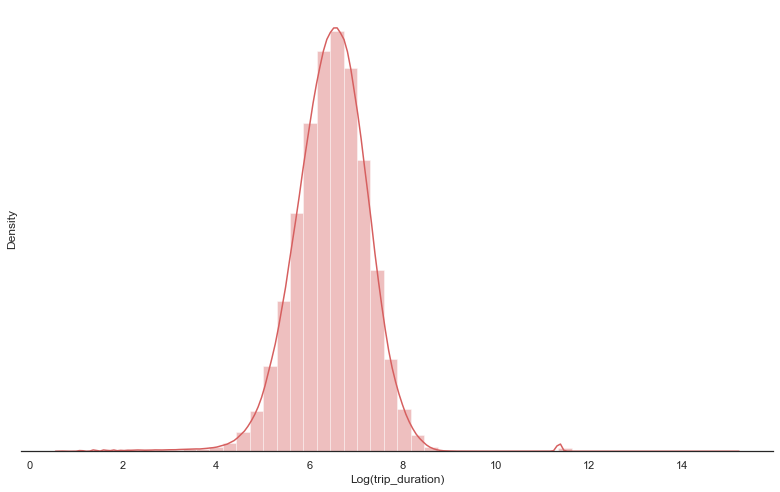

In [ ]:
%matplotlib inline

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

#### Note

It is clear with the above histogram and kernel density plot that the trip-durations are like Gaussian and few trips have very large duration, like ~350000 seconds which is 100 hours (which is weird, as long as it isn't an intercity taxi ride from NYC to SF or Alaska), while most of the trips are e^4 = 1 minute to e^8 ~ 60 minutes. and probably are taken inside Manhattan or in new york only. Let's check the lat-long distributions are then used them to have a heat map kind of view of given lat-longs.

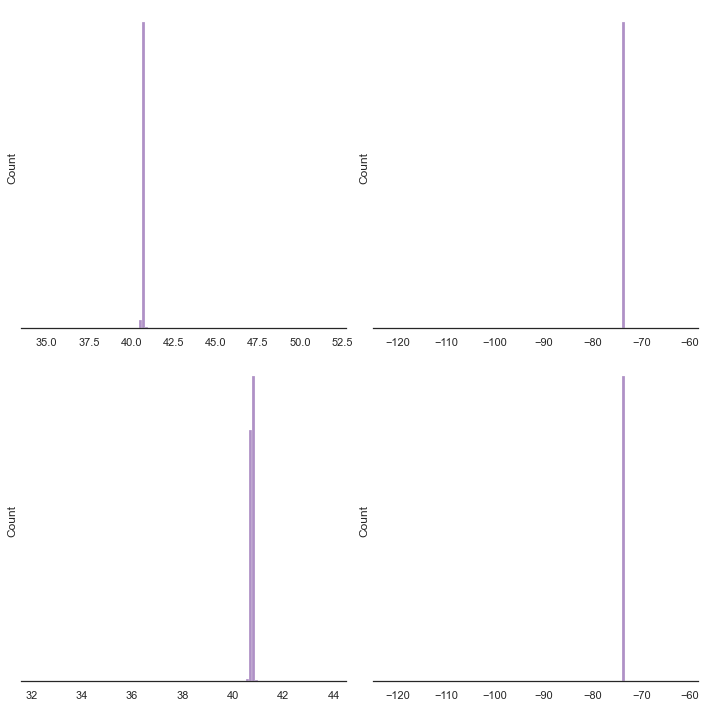

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.histplot(train_df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.histplot(train_df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.histplot(train_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.histplot(train_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

#### Note

From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 ton-73. We are not getting any histogram kind of plots when we are plotting lat-long as the distplot function of sns is getting affected by outliers, trips which are very far from each other like lat 32 to lat 44, are taking very long time, and have affected this plot such that it is coming off as a spike. Let's remove those large duration trip by using a cap on lat-long and visualize the distributions of latitude and longitude given to us.

1452385 1458644


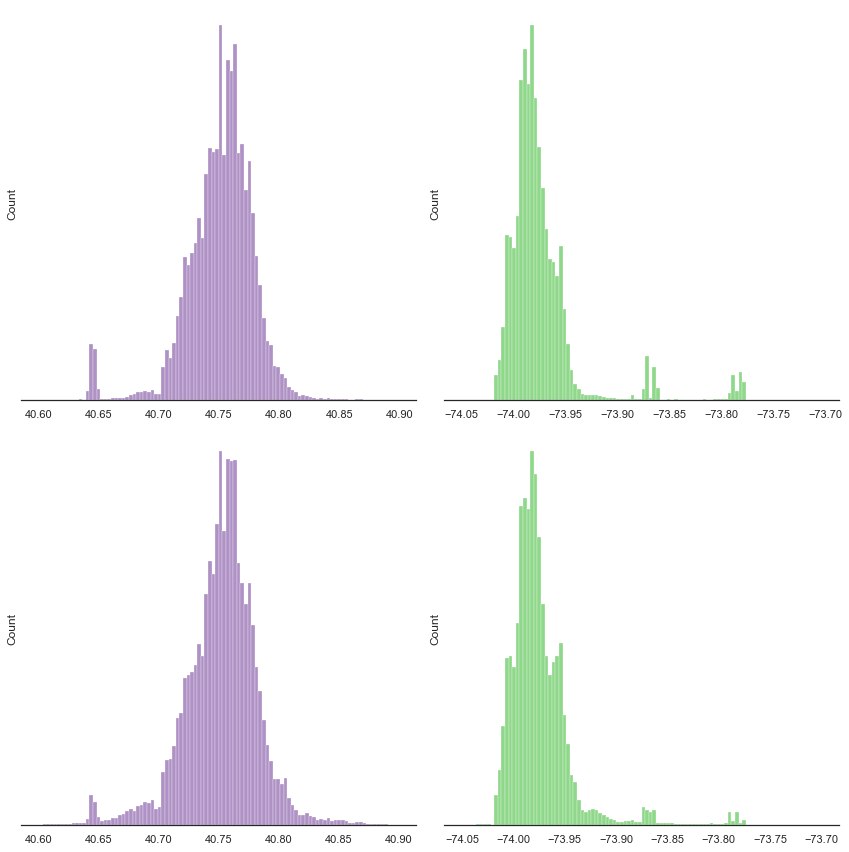

In [ ]:
df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)
sns.histplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.histplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.histplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.histplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

print(df.shape[0], train_data.shape[0])
plt.show()

#### Note

We put the following caps on lat-long -

* latitude should be between 40.6 to 40.9

* longitude should be between -74.05 to -73.70

We get that the distribution spikes becomes as distribution in distplot (distplot is a histogram plot in seaborn package), we can see that most of the trips are getting concentrated between these lat-long only. Let's plot them on an empty image.

In [ ]:
temp = train_data.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

ts_v1 = pd.DataFrame(train_data.loc[train_data['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train_data.loc[train_data.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
output_notebook()
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    df = data
    p.line(df['pick_date'], df['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)

train_data = temp

Loading BokehJS ...


### Heatmap of coordinates

We have taken an empty image and make it a color it black so that we can see colors where the lat-longs are falling. To visualize we need to consider each point of this image as a point represented by lat-long, to achieve that we will bring the lat-long to image coordinate range and then take a summary of lat-long and their count, assign a different color for different count range.

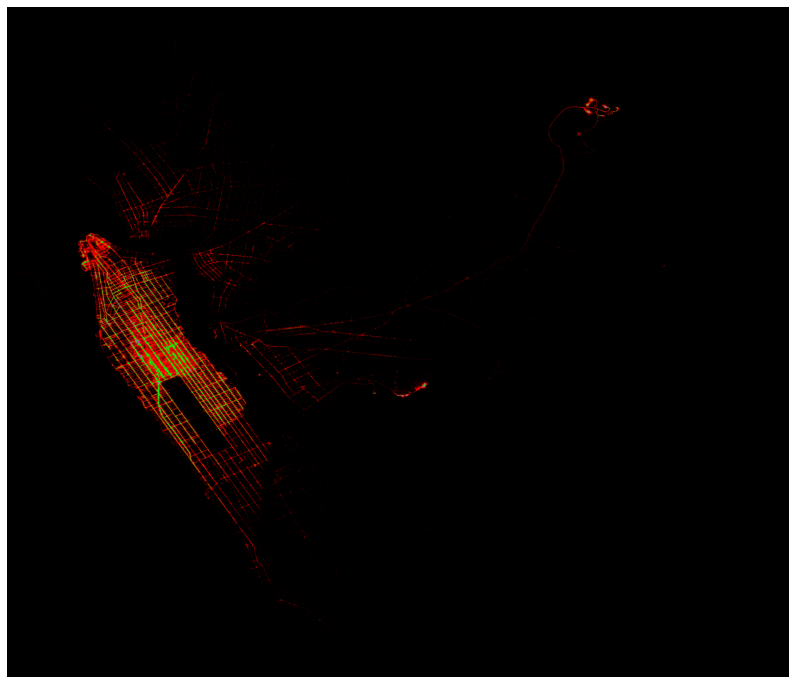

In [ ]:
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))

ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off()

#### Note

From the heatmap kind of image above -

* Red points signifies that 1-10 trips in the given data have that point as pickup point

* Green points signifies that more than 10-50 trips in the given data have that point as pickup point

* Yellow points signifies that more than 50+ trips in the given data have that point as pickup point

Clearly, the whole manhattan is yellow colored and with few green points as well, that shows that in Manhatten most of the trips are getting originated. This is the basic way in which we can plot large geospatial data in an empty image without being dependent on any package. But if you hate image processing, you can use datashader, datashader is a package which is used to show billions of data points on an image, they also use the similar approach with a different color gradient.

---
## NYC_taxi_trip_duration Data Understanding

In [ ]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = datetime.datetime.now()
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Check the data

In [ ]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663

In [ ]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))== 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'N', 'Y'}.


#### Dimension of the train data


In [ ]:
train.shape

(1458644, 11)

#### Description about the feature

In [ ]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

---
## Exploratory Data Analysis
---

### Handling null values
Train data has no null values.

In [ ]:
train.isnull().any()

id                    False
vendor_id             False
pickup_datetime       False
dropoff_datetime      False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag    False
trip_duration         False
dtype: bool

### Individual features EDA (before removing outliers)
#### Vendor ID count

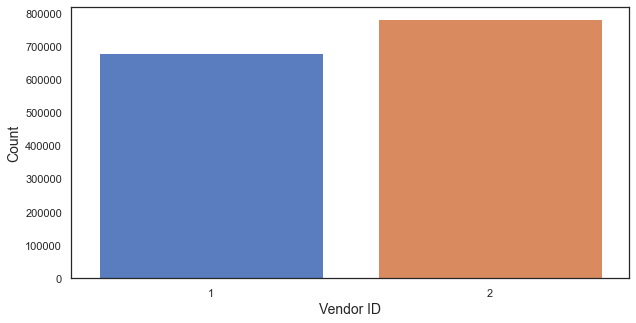

In [ ]:
f = plt.figure(figsize=(10,5))
sns.countplot(x='vendor_id', data=train_df)
plt.xlabel('Vendor ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

* 2 different vendors
* vendor_id = 2 more popular among passengers

#### Passenger count visualisation

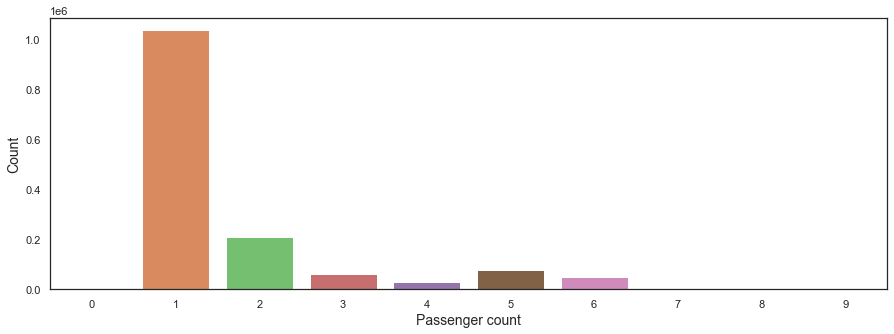

In [ ]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='passenger_count', data=train_df)
plt.xlabel('Passenger count', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

* Min no. of passengers = 0, max no. of passengers = 9

#### Trip Duration

In [ ]:
train_df["trip_duration"].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

<AxesSubplot:xlabel='trip_duration'>

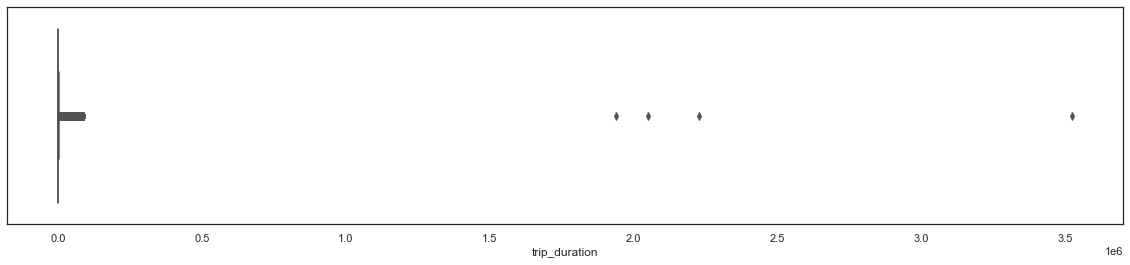

In [ ]:
plt.figure(figsize=(20, 4))
sns.boxplot(x=train_df["trip_duration"])

In [ ]:
longest_trip = format(train_df["trip_duration"].max()/(60.*60*24))

print(longest_trip)

40.81344907407407


* Longest trip duration ~ 41 days, could be due to driver forgetting to switch off the meter
* Shortest trip duration = 1 second, could be due to driver accidentally switching on the meter & off

Analyse data where trip duration <= 24 hours (86000 seconds)

In [ ]:
day_trip_duration = train_df.drop(train_df[train_df.trip_duration > 86400].index)

<AxesSubplot:xlabel='trip_duration', ylabel='Count'>

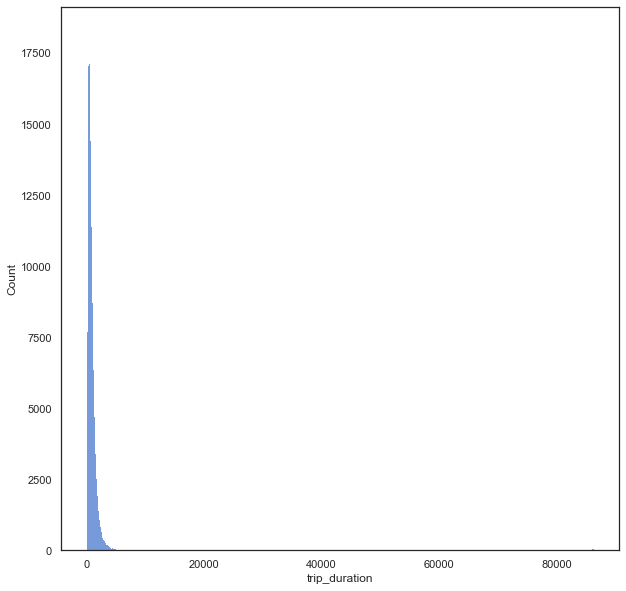

In [ ]:
plt.figure(figsize=(10, 10))
sns.histplot(data=day_trip_duration, x="trip_duration")

In [ ]:
fourhr_trip_duration = train_df.drop(train_df[train_df.trip_duration > 14400].index)

<AxesSubplot:xlabel='trip_duration', ylabel='Count'>

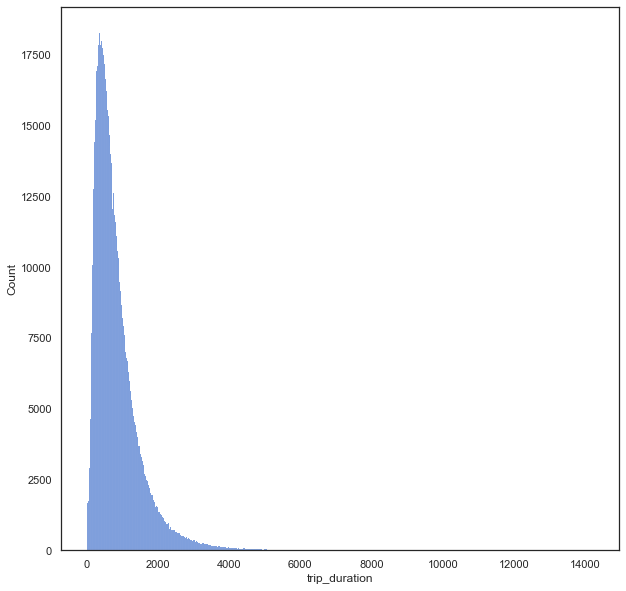

In [ ]:
plt.figure(figsize=(10, 10))
sns.histplot(data=fourhr_trip_duration, x="trip_duration")

* Most trips < 2000 seconds, less than half an hour

### Checking outliers in the data - Boxplot approach
My aim is to remove extreme outliers to prevent huge data loss.

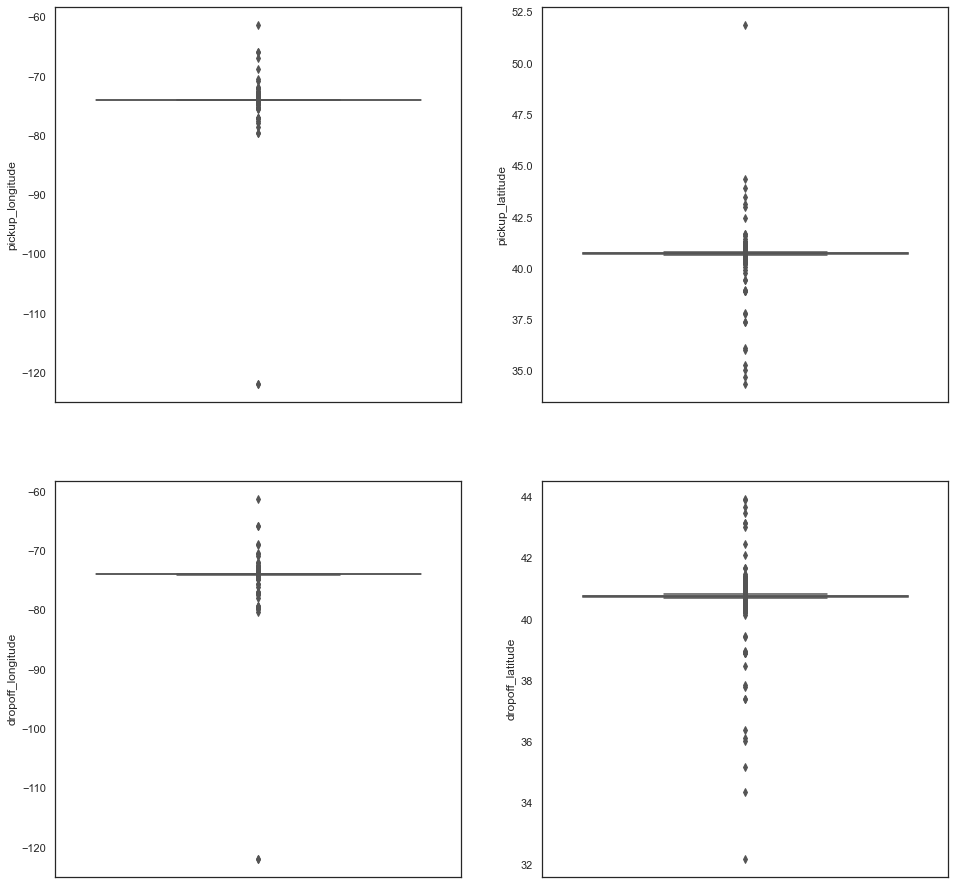

In [ ]:
f, axes = plt.subplots(2, 2,figsize=(16,16))

f = ['pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude']

i=0
for r in range(2):
    for c in range(2):
        sns.boxplot(y=train[f[i]],  orient='v' , ax=axes[r,c])
        i+=1

In [ ]:
train[(train.pickup_longitude < -100)]

id  vendor_id      pickup_datetime     dropoff_datetime  \
1068810  id3777240          2  2016-01-27 18:26:40  2016-01-27 18:45:05   
1184454  id2854272          2  2016-02-26 13:50:19  2016-02-26 13:58:38   

         passenger_count  pickup_longitude  pickup_latitude  \
1068810                2       -121.933235        37.389297   
1184454                2       -121.933342        37.389381   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
1068810        -121.933205         37.389103                  N           1105  
1184454        -121.933304         37.389511                  N            499

In [ ]:
train[(train.dropoff_longitude < -100)]

id  vendor_id      pickup_datetime     dropoff_datetime  \
1068810  id3777240          2  2016-01-27 18:26:40  2016-01-27 18:45:05   
1184454  id2854272          2  2016-02-26 13:50:19  2016-02-26 13:58:38   

         passenger_count  pickup_longitude  pickup_latitude  \
1068810                2       -121.933235        37.389297   
1184454                2       -121.933342        37.389381   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
1068810        -121.933205         37.389103                  N           1105  
1184454        -121.933304         37.389511                  N            499

In [ ]:
train[(train.pickup_latitude > 45)]

id  vendor_id      pickup_datetime     dropoff_datetime  \
184925  id2306955          1  2016-05-07 18:58:53  2016-05-07 19:12:05   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
184925                1        -72.809669        51.881084         -73.987228   

        dropoff_latitude store_and_fwd_flag  trip_duration  
184925         40.750599                  N            792

<AxesSubplot:>

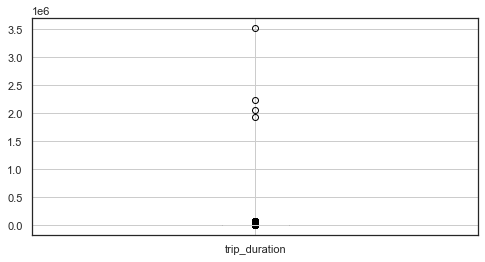

In [ ]:
train.boxplot(column=['trip_duration'],
                 figsize = (8,4))

In [ ]:
train[(train.trip_duration > 100000)]

id  vendor_id      pickup_datetime     dropoff_datetime  \
355003  id1864733          1  2016-01-05 00:19:42  2016-01-27 11:08:38   
680594  id0369307          1  2016-02-13 22:38:00  2016-03-08 15:57:38   
924150  id1325766          1  2016-01-05 06:14:15  2016-01-31 01:01:07   
978383  id0053347          1  2016-02-13 22:46:52  2016-03-25 18:18:14   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
355003                1        -73.789650        40.643559         -73.956810   
680594                2        -73.921677        40.735252         -73.984749   
924150                1        -73.983788        40.742325         -73.985489   
978383                1        -73.783905        40.648632         -73.978271   

        dropoff_latitude store_and_fwd_flag  trip_duration  
355003         40.773087                  N        1939736  
680594         40.759979                  N        2049578  
924150         40.727676                  N        2227612  
978383         40.750202                  N        3526282

---
### Feature Engineering

#### Removing outliers in train data

* We implemented the Interquartile range approach.

We have used the interquartile ranges method to remove the outliers with a high cuttoff value to prevent high data loss(in 100,000s) as it will affect the accuracy of the model. The interquartile method provided lower errors in prediction.

* We chose the cutoff value iteratively and chose which gave the best model accuracy.

* In total 53 outliers removed

### Interquartile Approach

In [ ]:
def outlier_detection_removal(data,feature):
    
    array = data[feature].values 
    q25 = np.percentile(array, 25)
    q75 = np.percentile(array,75)
    iqr = q75 - q25

    cutoff = iqr*30
    lower_threshold = q25 - cutoff
    upper_threshold = q75 + cutoff

    outliers = [a for a in array if a < lower_threshold or a > upper_threshold]
    print('\nNumber of outliers detected for feature {}: {}'.format(feature,len(outliers)))
    
    data = data.drop(data[(data[feature] > upper_threshold) | (data[feature] < lower_threshold)].index)
    print('Number of records after outlier removal: {}'.format(len(data)))
    return data

In [ ]:
train = train[(train.trip_duration < 100000)]
train = train[(train.pickup_longitude > -100)]
train = train[(train.dropoff_longitude > -100)]
train = train[(train.pickup_latitude < 45)]

train = outlier_detection_removal(train,'pickup_longitude')
train = outlier_detection_removal(train,'dropoff_longitude')
train = outlier_detection_removal(train,'pickup_latitude')
train = outlier_detection_removal(train,'dropoff_latitude')


Number of outliers detected for feature pickup_longitude: 34
Number of records after outlier removal: 1458603

Number of outliers detected for feature dropoff_longitude: 17
Number of records after outlier removal: 1458586

Number of outliers detected for feature pickup_latitude: 1
Number of records after outlier removal: 1458585

Number of outliers detected for feature dropoff_latitude: 1
Number of records after outlier removal: 1458584


### Z-score Approach

In [ ]:
'''
def z_score(data,feature):
    
    array = data[feature].values
    total_rec = len(data)
    
    mean = np.mean(array) 
    std = np.std(array)
    
    data['z_score_' + feature] = (data[feature] - mean)/std
    threshold = 125
    data = data[data['z_score_' + feature]<threshold]
    data = data[data['z_score_' + feature]> (threshold*(-1))]
            
            
        
    print('\nNumber of outliers detected for feature {}: {}'.format(feature,total_rec - len(data)))
    
        
    print('Number of records after outlier removal: {}'.format(len(data)))    
    return data

train_df = train_df[(train_df.trip_duration < 100000)]
train_df = train_df[(train_df.pickup_longitude > -100)]
train_df = train_df[(train_df.dropoff_longitude > -100)]
train_df = train_df[(train_df.pickup_latitude < 45)]

train_df = z_score(train_df,'pickup_longitude')
train_df = z_score(train_df,'dropoff_longitude')
train_df = z_score(train_df,'pickup_latitude')
train_df = z_score(train_df,'dropoff_latitude')
'''

### Feature Scaling

In [ ]:
'''
Train_df = train_df.copy()
Test_df = test_df.copy()

feature_scale=[feature for feature in Train_df.columns  if feature not in ['trip_duration']]

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
scaler=RobustScaler()
scaler.fit(Train_df[feature_scale])

test_feature_scale=[feature for feature in Test_df.columns]

scaler.transform(Train_df[feature_scale])

final_data = pd.concat([Train_df[['trip_duration']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(Train_df[feature_scale]), columns=feature_scale)],
                    axis=1)
final_test_data = pd.DataFrame(scaler.transform(Test_df[feature_scale]), columns=feature_scale)
'''

#### Converting date time string to datetime dtype

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


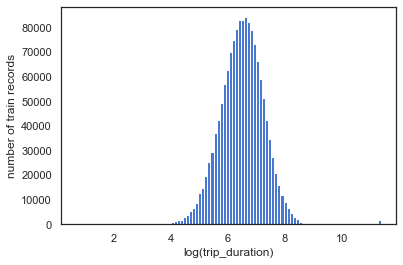

In [ ]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

#### Validation Strategy

First let's check the train test split. It helps to decide our validation strategy and gives ideas about feature engineering.

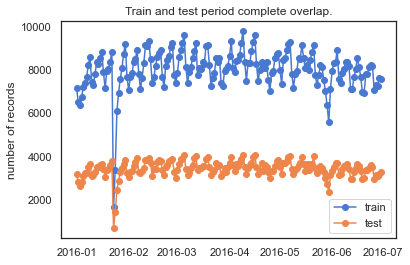

In [ ]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

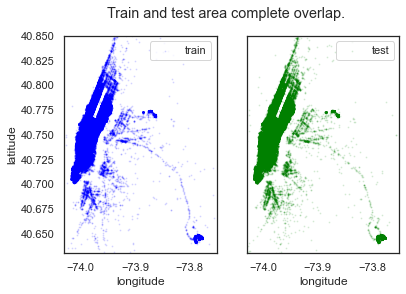

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In this case the train and test split seems to be random. This allows us to use unsupervised learning and feature extraction to be applied on the full data set.

---
## Feature Extraction

### PCA (Principal Component Analysis)
We use PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we transform 2D-> 2D. The rotation could help for decision tree splits.

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

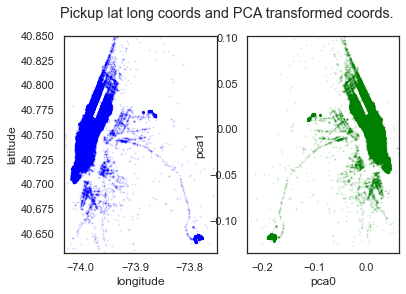

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

### Distance

Let's calculate the distance (km) between pickup and dropoff points. Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer. The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too.

pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays. We extraxt the middle of the path as a feature as well.

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

### Extracting all date time attirubutes into different features

#### Adding features which are domain specific

* Trips taken at night is taken into account.
* Trips taken during rush hours is taken into account.
* Trips taken during weekday/weekend is taken into account.
* Trips taken during or near to holidays in the US is taken into account.
* Trips taken during business days in the US is taken into account.

In [ ]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_month'] = train['pickup_datetime'].dt.month
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_week'] = train['pickup_datetime'].dt.week
train['pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_minute_of_the_day'] = train['pickup_hour'] * 60 + train['pickup_minute']
train['pickup_dayofyear'] = train['pickup_datetime'].dt.dayofyear
train['pickup_am'] = train['pickup_hour'] < 12

test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_week'] = test['pickup_datetime'].dt.week
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_minute_of_the_day'] = test['pickup_hour'] * 60 + test['pickup_minute']
test['pickup_dayofyear'] = test['pickup_datetime'].dt.dayofyear
test['pickup_am'] = test['pickup_hour'] < 12

# These time periods are based on visuls below
train['night_trip'] = [True if x < 7 else False for x in train['pickup_hour']]
train['rush_hour'] = [True if 9 < x < 20 else False for x in train['pickup_hour']]
train['weekday'] = [True if x < 5 else False for x in train['pickup_weekday']]
test['night_trip'] = [True if x < 7 else False for x in test['pickup_hour']]
test['rush_hour'] = [True if 9 < x < 20 else False for x in test['pickup_hour']]
test['weekday'] = [True if x < 5 else False for x in test['pickup_weekday']]


In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import timedelta

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.date_range(start = train.pickup_datetime.min(), 
                                 end = train.pickup_datetime.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

train['pickup_is_weekend'] = train.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)
train['pickup_holiday'] = pd.to_datetime(train.pickup_datetime.dt.date).isin(holidays)
train['pickup_holiday'] = train.pickup_holiday.map(lambda x: 1 if x == True else 0)

train['pickup_near_holiday'] = (pd.to_datetime(train.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) |
                             pd.to_datetime(train.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
train['pickup_near_holiday'] = train.pickup_near_holiday.map(lambda x: 1 if x == True else 0)
train['pickup_businessday'] = pd.to_datetime(train.pickup_datetime.dt.date).isin(business_days)
train['pickup_businessday'] = train.pickup_businessday.map(lambda x: 1 if x == True else 0)

test_business_days = pd.date_range(start = test.pickup_datetime.min(), 
                                 end = test.pickup_datetime.max(), 
                                 freq = us_bd)
test_business_days = pd.to_datetime(test_business_days).date

test['pickup_is_weekend'] = test.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)
test['pickup_holiday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(holidays)
test['pickup_holiday'] = test.pickup_holiday.map(lambda x: 1 if x == True else 0)

test['pickup_near_holiday'] = (pd.to_datetime(test.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) |
                             pd.to_datetime(test.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
test['pickup_near_holiday'] = test.pickup_near_holiday.map(lambda x: 1 if x == True else 0)
test['pickup_businessday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(test_business_days)
test['pickup_businessday'] = test.pickup_businessday.map(lambda x: 1 if x == True else 0)


### Feature Engineering EDA
#### Passenger pickup count

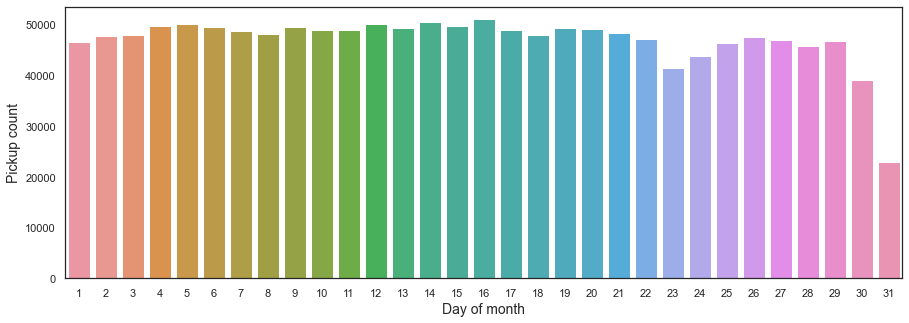

In [ ]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_day', data=train)
plt.xlabel('Day of month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

* Number of pickups almost consistent throughout the month
* Lesser pickups on the 31st (since some months do not have day 31)

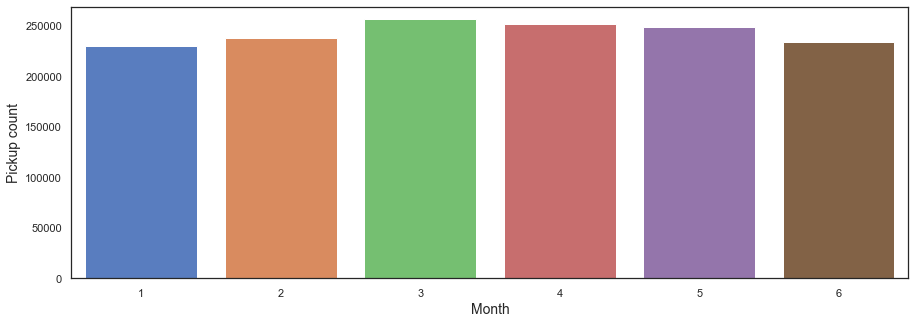

In [ ]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_month', data=train)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

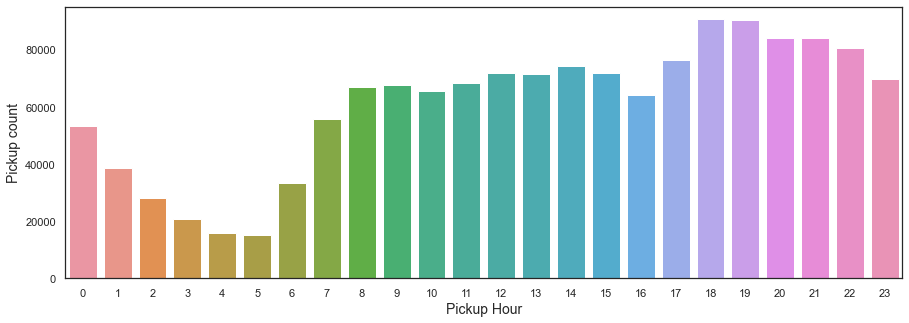

In [ ]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_hour', data=train)
plt.xlabel('Pickup Hour', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

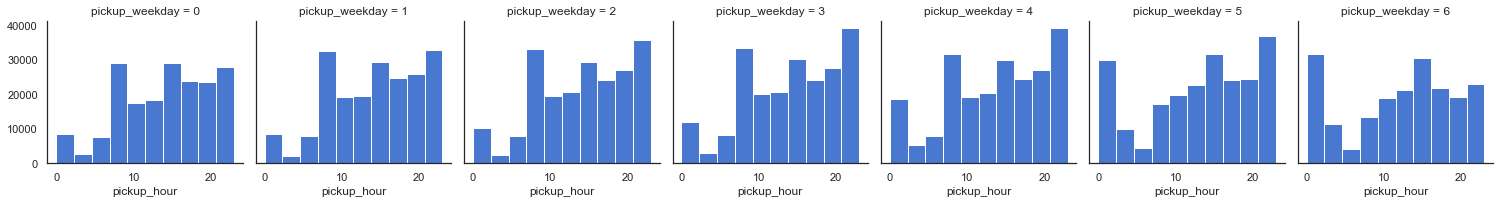

In [ ]:
g = sns.FacetGrid(train, col="pickup_weekday")
g.map(plt.hist, "pickup_hour");

* More pickups after midnight on weekends (Saturday and Sunday)
* Generally more pickups during peak period on weekdays (when people go to work/ after work)

### Speed

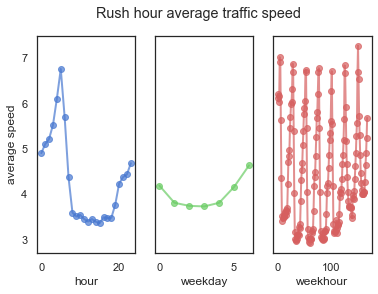

In [ ]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

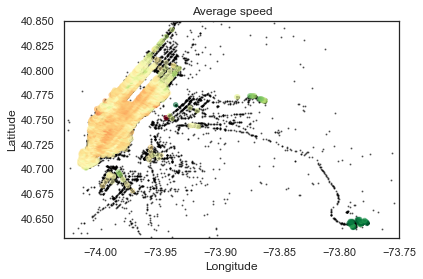

In [ ]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

-----
## Clustering


In [ ]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = datetime.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 85 seconds


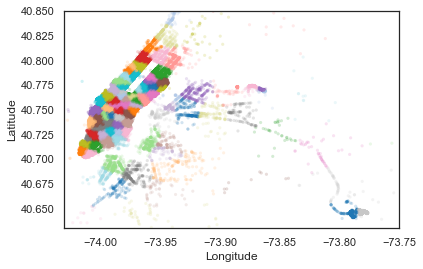

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Temporal and geospatial aggregation
Add a few average traffic speed features. Note that if the train/test split would be time based then we could not use as much temporal features.

In [ ]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [ ]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.Grouper(freq=group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [ ]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.Grouper(freq=group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

---
### Take advantage of OSRM features
We had only rough distance estimates in the previous versions. Now we use better fastest route distance estimates between pickup and dropoff.

In [ ]:
fr1 = pd.read_csv('fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

id  total_distance  total_travel_time  number_of_steps
0  id2875421          2009.1              164.9                5
1  id2377394          2513.2              332.0                6
2  id3504673          1779.4              235.8                4
3  id2181028          1614.9              140.1                5
4  id0801584          1393.5              189.4                5

In [ ]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = datetime.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 72 features.
Feature extraction time: 158 seconds


In [ ]:
train[feature_names].values.astype(float)

array([[ 2.00000000e+00,  1.00000000e+00, -7.39821548e+01, ...,
         2.00910000e+03,  1.64900000e+02,  5.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00, -7.39804153e+01, ...,
         2.51320000e+03,  3.32000000e+02,  6.00000000e+00],
       [ 2.00000000e+00,  1.00000000e+00, -7.39790268e+01, ...,
         1.10608000e+04,  7.67600000e+02,  1.60000000e+01],
       ...,
       [ 2.00000000e+00,  1.00000000e+00, -7.39591293e+01, ...,
         9.87150000e+03,  6.42900000e+02,  1.00000000e+01],
       [ 1.00000000e+00,  1.00000000e+00, -7.39820786e+01, ...,
         1.62830000e+03,  1.61600000e+02,  7.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00, -7.39795380e+01, ...,
         1.13420000e+03,  9.07000000e+01,  2.00000000e+00]])

### Feature check before modeling
It might save us some headache to check our train and test feature distributions before modeling. Usually in kaggle competitions train and test sets are iid. If there is huge differenc between train and test set than probably we have a bug in our feature extraction pipeline.

In [ ]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values.astype(float), axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values.astype(float), axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values.astype(float), axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values.astype(float), axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values.astype(float)), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values.astype(float)), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

feature  train_test_mean_diff
34                         pickup_near_holiday              0.003225
2                             pickup_longitude              0.003578
7                                  pickup_pca0              0.003587
4                            dropoff_longitude              0.003673
64  avg_speed_h_pickup_cluster_dropoff_cluster              0.004047

In [ ]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

feature  train_nan  test_nan  \
20                                 pickup_hour      0.000     0.000   
11                          distance_haversine      0.000     0.000   
41                 avg_speed_h_gby_pickup_date      0.000     0.000   
65          cnt_pickup_cluster_dropoff_cluster      0.107     0.108   
64  avg_speed_h_pickup_cluster_dropoff_cluster      0.107     0.108   

    train_test_nan_diff  
20                0.000  
11                0.000  
41                0.000  
65                0.001  
64                0.001

---
## Explore the Spatial and Temporal Behavior of the People

We are going to explore the spatial and temporal behavior of the people of New York as can be inferred by examining their cab usage.

We will see how the patterns of cab usage change throughout the week and throughout the day, and we will focus on difference between weekdays and weekends.

In [ ]:
taxiDB = pd.read_csv('train.csv')

# remove obvious outliers
allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(taxiDB['trip_duration'], 0.4), np.percentile(taxiDB['trip_duration'], 99.7)]

taxiDB = taxiDB[(taxiDB['pickup_latitude']   >= latLimits[0] ) & (taxiDB['pickup_latitude']   <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['dropoff_latitude']  >= latLimits[0] ) & (taxiDB['dropoff_latitude']  <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['pickup_longitude']  >= longLimits[0]) & (taxiDB['pickup_longitude']  <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['dropoff_longitude'] >= longLimits[0]) & (taxiDB['dropoff_longitude'] <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['trip_duration']     >= durLimits[0] ) & (taxiDB['trip_duration']     <= durLimits[1]) ]
taxiDB = taxiDB.reset_index(drop=True)

allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

taxiDB['duration [min]'] = taxiDB['trip_duration']/60.0
taxiDB['src lat [km]']   = latMultiplier  * (taxiDB['pickup_latitude']   - medianLat)
taxiDB['src long [km]']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dst lat [km]']   = latMultiplier  * (taxiDB['dropoff_latitude']  - medianLat)
taxiDB['dst long [km]']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(taxiDB['src lat [km]'])  + list(taxiDB['dst lat [km]']))
allLong = np.array(list(taxiDB['src long [km]']) + list(taxiDB['dst long [km]']))

### Plot the resulting histograms of trip duration, latitude and longitude

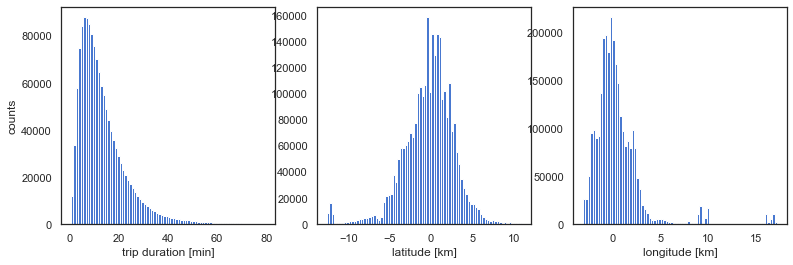

In [ ]:
# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
axArray[0].hist(taxiDB['duration [min]'],80); 
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')
plt.show()

### Plot spatial density plot of the pickup and dropoff locations

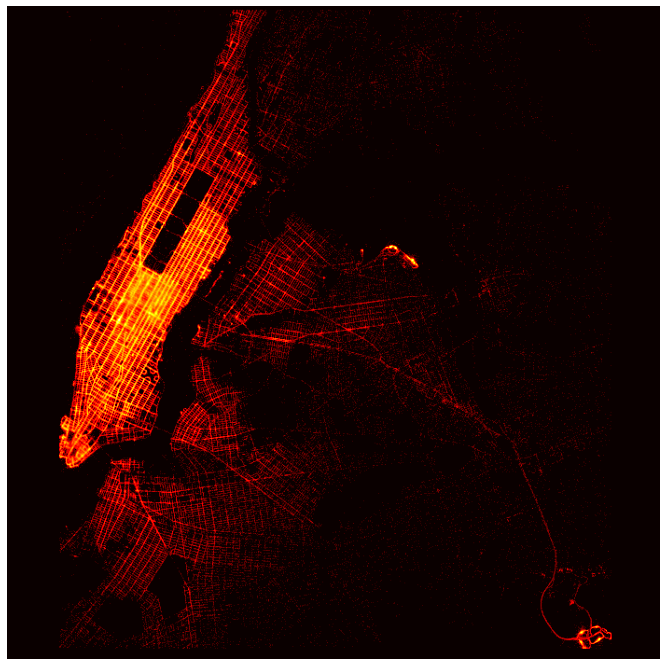

In [ ]:
# show the log density of pickup and dropoff locations
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

plt.show()

### Create parameters that will be used later

In [ ]:
# create some new usefull fields
pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

taxiDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

taxiDB['dayOfWeek']     = pickupTime.dt.weekday
taxiDB['hourOfWeek']    = taxiDB['dayOfWeek']*24.0 + taxiDB['src hourOfDay']

taxiDB['monthOfYear']   = pickupTime.dt.month
taxiDB['dayOfYear']     = pickupTime.dt.dayofyear
taxiDB['weekOfYear']    = pickupTime.dt.weekofyear
taxiDB['hourOfYear']    = taxiDB['dayOfYear']*24.0 + taxiDB['src hourOfDay']

### Cluster The Trips and Look at their distribution

Every trip is essentially made up of 5 major attributes: pickup and dropoff locations and the trip duration. let's cluster all 1.4 million trips to 80 stereotypical template trips and then look at the distribution of this "bag of trips" and how it changes over time

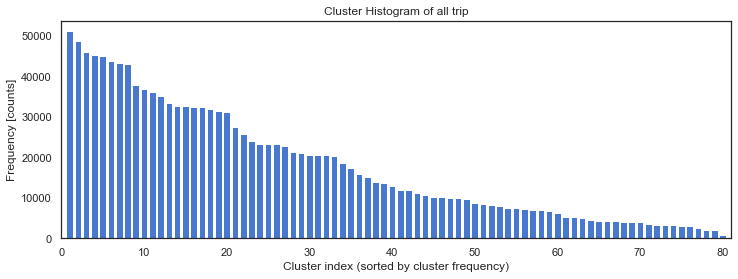

In [ ]:
from scipy import stats
from sklearn import cluster
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=12000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)
plt.show()

### WeekDay Trip Distribution for different hours of the day
How does this "bag of trips" changes during the regular work day?

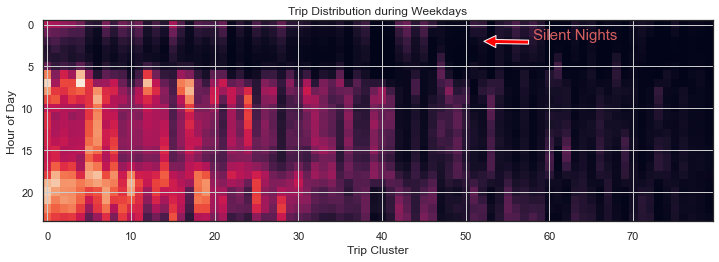

In [ ]:
# calculate the trip distribution for different hours of the weekday
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekdays', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekday); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Silent Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

plt.show()

Each row contains the "bag of trips" distribution where intensity represents trip frequency.

We can see that around 6AM people start waking up and (most likely) heading off to work. There is a second surge of taxi rides at around 18:00/19:00 (6PM/7PM) which is (most likely) people getting back home. It's also extreemly evindent that during weedays, people are almost not active during the night. This is marked by the red arrow.

### WeekEnd Trip Distribution for different hours of the day
How does this "bag of trips" changes during the weekend?

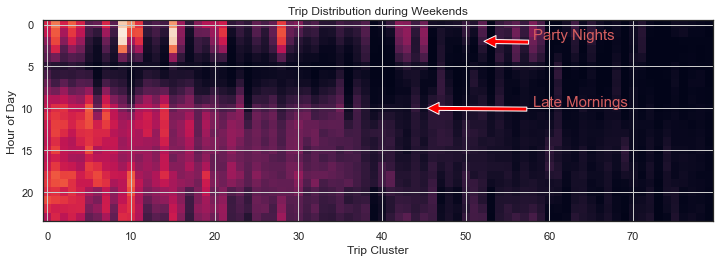

In [ ]:
# calculate the trip distribution for different hours of the weekend
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekends', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekend); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Party Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Late Mornings', color='r', fontsize=15, xy=(45, 10), xytext=(58, 9.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
plt.show()


We can see that during weekends, people are much more active during the night, and also are starting their day much later in the day when compared to regular weekdays. The red arrows mark these two time points on the graph.

### Weekly Trip Distribution for different days of the week

How does this "bag of trips" changes during the week?

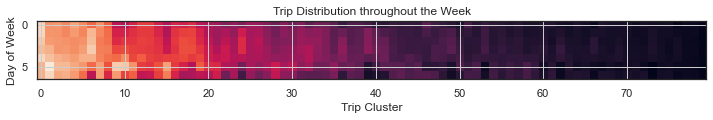

In [ ]:
# calculate the trip distribution for day of week
daysOfWeek = np.sort(taxiDB['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = taxiDB['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,5)); plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Week')
plt.show()

We can see a reflection of what we saw from the two previous plots here. that during weekends, the pattern of trip distributions is somewhat different than that during the weekday.

---

The code below saves the modified data, that is, saves the train and test data with the features we have engineered and selected. 

The modified data is saved for done for both train and test sets, with one version being complete, and the other with only the important (selected) features.

In [ ]:
train_full = train
train_main = train[feature_names]

print(f"Train - Full: {train_full.shape}")
print(f"Train - Main Features: {train_main.shape}")

In [ ]:
test_full = test
test_main = test[feature_names]

print(f"Test - Full: {test_full.shape}")
print(f"Test - Main Features: {test_main.shape}")

In [ ]:
train_main.to_csv("/content/drive/MyDrive/NYC Taxi Trip Duration/15-April/v2/train_main_features.csv", index=False)
test_main.to_csv("/content/drive/MyDrive/NYC Taxi Trip Duration/15-April/v2/test_main_features.csv", index=False)

In [ ]:
train_full.to_csv("/content/drive/MyDrive/NYC Taxi Trip Duration/15-April/v2/train_complete.csv", index=False)
test_full.to_csv("/content/drive/MyDrive/NYC Taxi Trip Duration/15-April/v2/test_complete.csv", index=False)

## Modelling - XGBoost

In [ ]:
import xgboost as xgb
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 10, 'eta': 0.04, 'colsample_bytree': 0.8, 'max_depth': 15,
            'subsample': 0.8, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# xgb_pars = {'min_child_weight': 10, 'eta': 0.04, 'colsample_bytree': 0.3, 'max_depth': 10,
           # 'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
           #'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
model = xgb.train(xgb_pars, dtrain, 2000, watchlist, early_stopping_rounds=250,
                  maximize=False, verbose_eval=15)

# model = xgb.train(xgb_pars, dtrain, 2000, watchlist, early_stopping_rounds=250,
               #   maximize=False, verbose_eval=10)

[0]	train-rmse:5.78033	valid-rmse:5.77988
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 250 rounds.
[15]	train-rmse:3.15287	valid-rmse:3.15377
[30]	train-rmse:1.74045	valid-rmse:1.74381
[45]	train-rmse:0.993739	valid-rmse:1.00272
[60]	train-rmse:0.614164	valid-rmse:0.634649
[75]	train-rmse:0.435055	valid-rmse:0.471346
[90]	train-rmse:0.357796	valid-rmse:0.40866
[105]	train-rmse:0.325423	valid-rmse:0.38685
[120]	train-rmse:0.310407	valid-rmse:0.379266
[135]	train-rmse:0.300834	valid-rmse:0.376278
[150]	train-rmse:0.294105	valid-rmse:0.374768
[165]	train-rmse:0.288257	valid-rmse:0.373852
[180]	train-rmse:0.28298	valid-rmse:0.373167
[195]	train-rmse:0.278731	valid-rmse:0.372668
[210]	train-rmse:0.274862	valid-rmse:0.372297
[225]	train-rmse:0.271207	valid-rmse:0.371846
[240]	train-rmse:0.267592	valid-rmse:0.371493
[255]	train-rmse:0.264787	valid-rmse:0.371239
[270]	train-rmse:0.261901	valid-rmse:0.37097

In [ ]:
print('Modeling RMSLE %.5f' % model.best_score)
t1 = datetime.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.36751
Training time: 38450 seconds


In [ ]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_duration'] = np.exp(ytest) - 1

Test shape OK.


Valid prediction mean: 6.468
Test prediction mean: 6.468


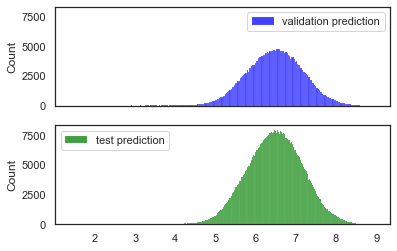

Total time: 39897 seconds


In [ ]:
ypred = model.predict(dvalid)

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.histplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = datetime.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

#### The distributions look like identical. We are ready for submission.

In [ ]:
test[['id', 'trip_duration']].to_csv('submission_xgb.csv', index=False)

### XGB Parameter Search Result
For hyperparameter tuning, we will use the random search. We try different values for the following parameters

* min_child_weight
* eta 
* colsample_bytree 
* max_depth -subsample 
* lambda

In [ ]:
# flag for parameter searching
FOREVER_COMPUTING_FLAG = False
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)

These experiments would take much time, so a subset of the result is copied here for visualization.

In [ ]:
paropt = pd.DataFrame({'lambda':[1.5,1.0,1.0,1.5,1.5,1.0,1.5,1.0,1.5,2.0,0.5,1.0,0.5,1.5,1.5,0.5,1.0,1.5,0.5,2.0,1.0,2.0,2.0,1.5,1.5,2.0,1.5,2.0,1.5,0.5,1.0,1.0,2.0,1.5,1.0,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,1.0,0.5,0.5,1.5,0.5,1.5,2.0,2.0,2.0,2.0,0.5,1.5,1.0,1.5,2.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,2.0,1.0,1.0,2.0,2.0,1.0,0.5,0.5,1.0,1.5,2.0,0.5,1.0,1.5,1.0,1.0,1.5,1.5,1.5,0.5,1.5,1.0,1.5,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.5,1.5,0.5,2.0,0.5,1.0,1.5,1.5,1.5,2.0,0.5,0.5,1.0,2.0],
                       'eta':[.1,.1,.05,.05,.05,.15,.15,.1,.1,.05,.15,.15,.15,.1,.1,.1,.1,.05,.15,.05,.05,.05,.15,.15,.05,.05,.05,.05,.15,.15,.15,.15,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.1,.1,.05,.05,.15,.15,.15,.1,.1,.05,.05,.05,.05,.05,.15,.1,.1,.15,.1,.1,.05,.15,.15,.15,.1,.05,.05,.05,.05,.15,.1,.1,.1,.1,.05,.05,.05,.15,.15,.1,.1,.1,.1,.05,.15,.15,.1,.1,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.15,.05,.05,.15,.15],
                       'min_child_weight': [50,50,20,100,10,50,100,100,75,10,10,50,50,100,75,100,50,10,20,10,75,20,50,75,100,100,10,20,75,75,75,20,10,75,10,100,100,10,20,20,50,50,100,20,50,100,100,75,20,75,20,50,20,10,20,20,20,75,20,75,100,10,10,20,10,20,100,75,75,10,100,50,100,100,50,10,75,75,50,10,75,75,50,75,20,100,100,50,20,20,50,50,75,20,50,100,75,75,100,75,10,10,20,20,10,10,75,50,20],
                       'subsample':[.8,.9,.8,.6,.6,.6,.9,.6,.5,.9,.8,.9,.7,.5,.5,.9,.7,.7,.5,.8,.5,.9,.6,.6,.8,.8,.8,.7,.5,.5,.9,.9,.5,.6,.7,.8,.8,.6,.9,.7,.8,.6,.6,.9,.7,.7,.8,.6,.6,.5,.9,.8,.7,.6,.6,.6,.5,.9,.8,.5,.7,.6,.8,.6,.8,.8,.6,.7,.9,.5,.7,.5,.9,.7,.8,.9,.9,.7,.8,.5,.7,.8,.6,.8,.8,.5,.9,.5,.5,.7,.8,.6,.6,.8,.7,.6,.6,.6,.7,.7,.8,.6,.5,.9,.7,.6,.9,.5,.5],
                       'rmse': [.380,.380,.377,.378,.378,.386,.382,.382,.383,.374,.386,.381,.385,.383,.383,.379,.381,.376,.389,.375,.381,.374,.385,.385,.378,.377,.375,.376,.385,.386,.382,.384,.384,.379,.376,.380,.380,.382,.380,.382,.378,.385,.384,.383,.383,.383,.379,.381,.386,.387,.381,.380,.380,.377,.377,.377,.379,.376,.382,.385,.382,.386,.380,.382,.375,.383,.385,.384,.379,.378,.380,.381,.378,.384,.380,.377,.379,.383,.380,.380,.380,.383,.385,.381,.379,.386,.380,.383,.387,.383,.382,.384,.385,.377,.380,.383,.383,.383,.382,.382,.377,.386,.388,.382,.384,.379,.378,.387,.388]
                       })

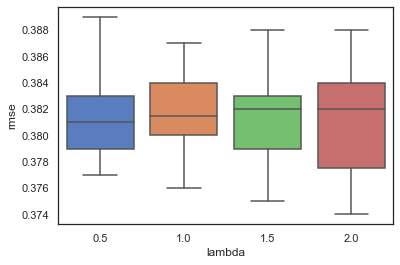

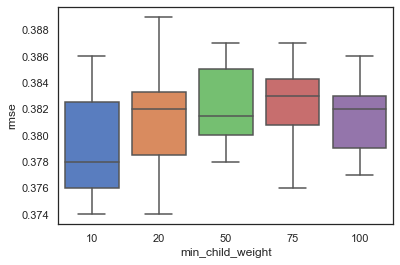

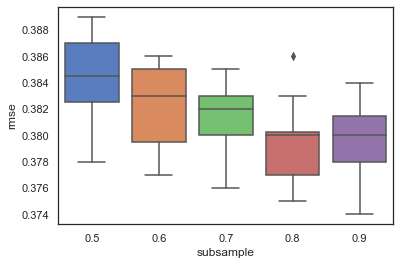

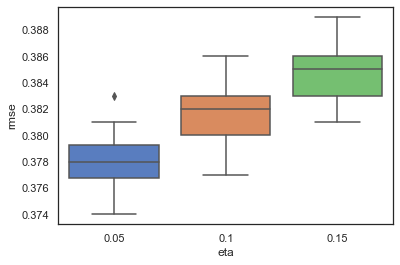

In [ ]:
for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=par, y="rmse", data=paropt)
plt.show()

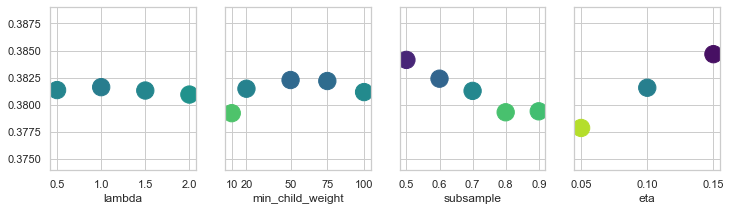

In [ ]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(12, 3))
    for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
        mean_rmse = paropt.groupby(par).mean()[['rmse']].reset_index()
        axs[i].scatter(mean_rmse[par].values, mean_rmse['rmse'].values, c=mean_rmse['rmse'].values,
                       s=300, cmap='viridis_r', vmin=.377, vmax=.385, )
        axs[i].set_xlabel(par)
        axs[i].set_xticks(mean_rmse[par].values)
        axs[i].set_ylim(paropt.rmse.min(), paropt.rmse.max())
plt.show()

We can see that lower eta could improve the performance significantly. Higher subsample and smaller child limit leads to better results too. Lambda does not really matter.

---
## Neural Network


**For Neural Networks, the source code is provided in the auxiliary file named "NeuralNetworks_Auxiliary_Code.ipynb".** 

This is to allow the notebook to be run independently, and to be run in parallel in multiple sessions (i.e. separate Google Colaboratory sessions for increased parallelization).

Note: the Neural Networks code requires this notebook to be run to generate the modified data (data with engineered and selected features).